<a href="https://colab.research.google.com/github/CrashingGuru/FGAN-Build-a-thon/blob/main/Notebooks2022/build_a_thon_graph_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vrra/FGAN-Build-a-thon-2022/blob/main/Notebooks2022/build_a_thon_graph_v1.ipynb)

## Build-a-thon 2022, Hoist the colors?
v1.0 release on 24 Aug 2022
Metrics: 325 nodes, 592 relations

In [1]:
!rm -rf /tmp/FGAN-Build-a-thon-2022/
!git clone https://github.com/vrra/FGAN-Build-a-thon-2022.git /tmp/FGAN-Build-a-thon-2022


Cloning into '/tmp/FGAN-Build-a-thon-2022'...
remote: Enumerating objects: 1114, done.
remote: Counting objects: 100% (447/447), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 1114 (delta 342), reused 262 (delta 209), pack-reused 667
Receiving objects: 100% (1114/1114), 7.16 MiB | 24.95 MiB/s, done.
Resolving deltas: 100% (614/614), done.


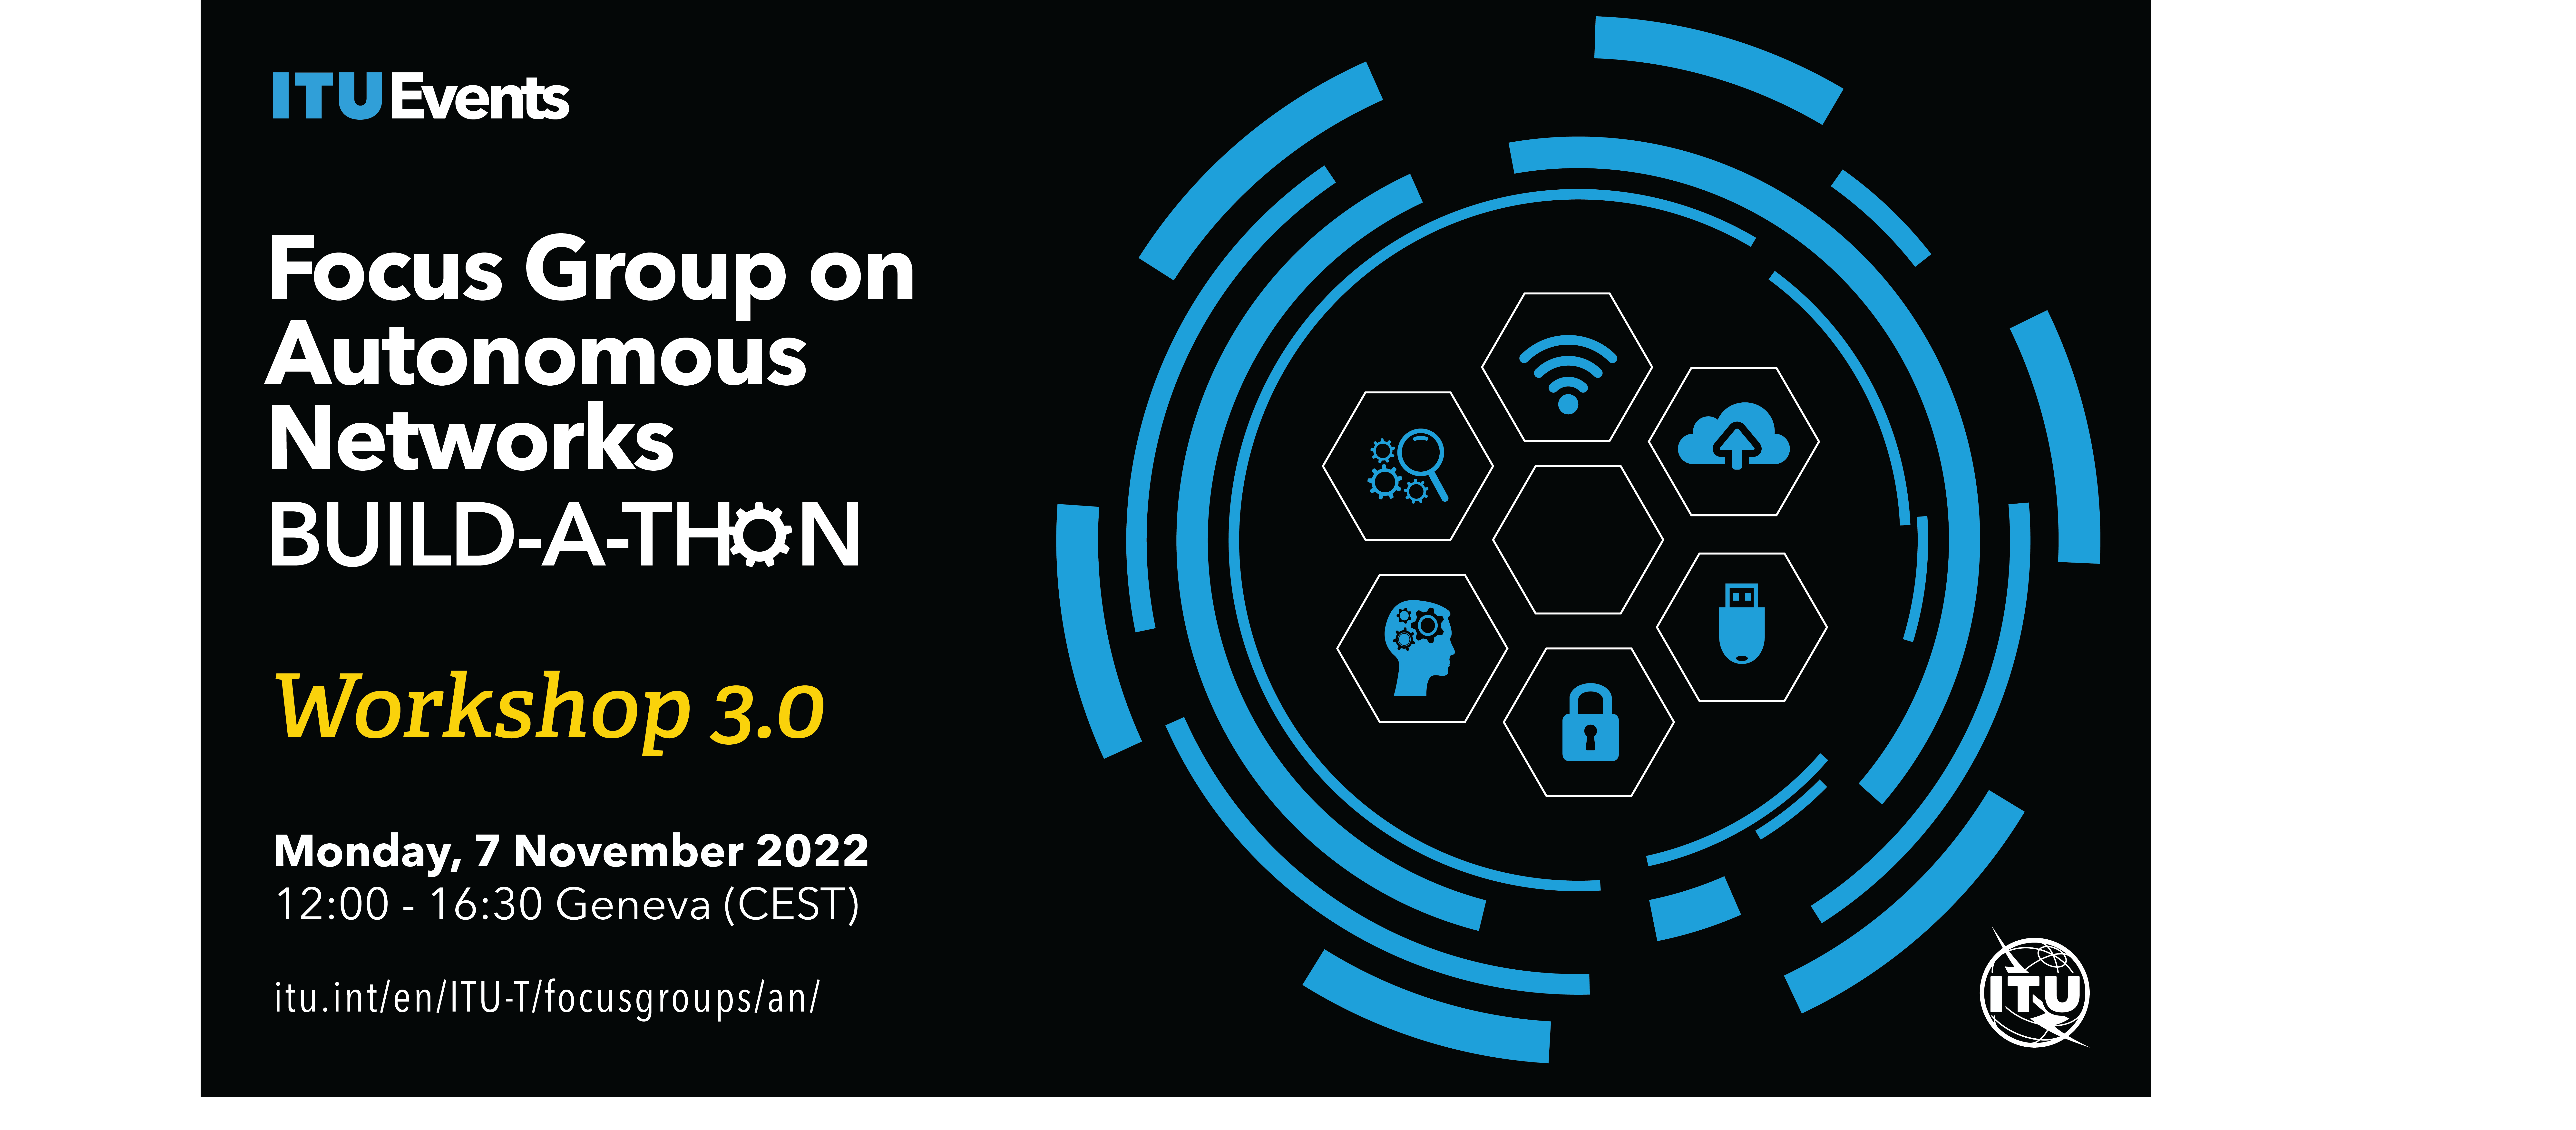

In [2]:
from IPython.display import Image
Image(filename='/tmp/FGAN-Build-a-thon-2022/Banner/1920x1080-FG_AN-buildathon-3.png', width=500)


In [3]:
!rm -rf /tmp/FGAN-Build-a-thon-2022/

## Introduction

Created: 14 Apr 2022.   
Author: Vishnu Ram OV.   
vishnu.n@ieee.org.   
Licence: available for all purposes under the sun  
but with acknowledgement and citation to "ITU FG AN Build-a-thon 2022"


## References
[1] Neo4j Docs, "Creating an instance", https://neo4j.com/docs/aura/auradb/getting-started/create-database/   
[2] ITU-T Focus Group Autonomous Networks, "Use cases for Autonomous Networks", https://extranet.itu.int/sites/itu-t/focusgroups/an/output/FGAN-O-013-R1.docx  
[3] Build-a-thon github, https://github.com/vrra/FGAN-Build-a-thon-2022

## Prerequisite:
create a free account at https://console.neo4j.io  
Follow steps at https://extranet.itu.int/sites/itu-t/focusgroups/an/input/FGAN-I-253.pdf  


## General cautions
Property names have strict conventions and rules in neo4j (apparently)

### For Colab users:

If you are using colab, add your credentials here and uncomment these  
and skip to step-1 below.

In [ ]:
#uri = "your uri from console.neo4j.io"
#user = "your username from console.neo4j.io"
#password = "your passwd from console.neo4j.io"

### For non-colab users:
Create a local file .env with   
neo4j_uri="your uri from console.neo4j.io"  
neo4j_user="your username from console.neo4j.io"  
neo4j_password="your passwd from console.neo4j.io"  

#### Read the neo4j URI, username, passwd


In [4]:
import os
%pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

False

In [5]:

#Vishnu: 1 Jun 2022: use the details from https://console.neo4j.io
#especially use your own DB instance and corresponding passwd.
#if you dont have a .env file, replace here with your credentials.
from google.colab import userdata

uri = userdata.get('neo4j_uri')
user = userdata.get('neo4j_user')
password = userdata.get('neo4j_password')

## step-1: install neo4j

In [6]:
%pip install neo4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.17.0-py3-none-any.whl size=273834 sha256=6566ffcf1893f7fea8e6bb167143ffd6ec5a56e10c0f59002c8286fa74b669a9
  Stored in directory: /root/.cache/pip/wheels/26/a1/15/63d729065b1a6a8afce3343003ca05bdbed2c4c05a707da4a3
Successfully built neo4j


## step-2: imports and init

In [ ]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable

## step-3: define helper class

In [ ]:


class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    #Vishnu: 1 Aug 2022: uses labels instead of properties
    #Vishnu: 1 Aug 2022: Invariant: only 1 actor with 1 name.
    #        (Note that rel still uses properties and not labels)
    def create_node_with_usecase_label(self, actor_name, usecase_id):
        with self.driver.session() as session:
            node_already_exists = session.read_transaction(
                self._find_and_return_existing_node_label, actor_name)
            if not node_already_exists:
                #node itself doesnt exist (not to mention the use case label), Lets add.
                result = session.write_transaction(
                    self._create_and_return_node_label, actor_name, usecase_id)
                for row in result:
                    print("Created node: {n1}".format(n1=row['n1name']))
            else:
                for row in node_already_exists:
                    print("Node already exists: {name} in {usecase}".format(name=row['n1name'],
                                                                 usecase=row['n1usecase']))
                    if not (usecase_id in row['n1usecase']):
                      print("adding label "
                                +usecase_id+
                                " in addition to {usecase}".format(usecase=row['n1usecase']))
                      result = session.write_transaction(
                                self._add_usecase_and_return_existing_node_label, actor_name, usecase_id)
                    else:
                      print("ignoring ...")
                    #row has only 1 entry due to invariant. So break here. and exit f()
                    break

    #Vishnu: 1 Aug 2022: created this f() to query nodes based on a name
    #                    and return with usecase labels
    @staticmethod
    def _find_and_return_existing_node_label(tx, actor_name):
        query = (
            "MATCH (n1) "
            "WHERE (n1.name ='" + actor_name + "') "
            "RETURN n1.name as n1name, labels(n1) as n1usecase"
        )
        result = tx.run(query)
        try:
            return [{"n1name": row["n1name"],"n1usecase": row["n1usecase"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: created this f() to create nodes with usecase label
    @staticmethod
    def _create_and_return_node_label(tx, actor_name, usecase_id):
            query = (
            "CREATE (n1 :" + usecase_id + " { name: '" + actor_name + "'}) "
            "RETURN n1"
            )
            result = tx.run(query, actor_name=actor_name)
            try:
                return [{"n1name": row["n1"]["name"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Aug 2022: created this f() to add use case labels to existing nodes
    #                    Note that the existing labels are left there.
    @staticmethod
    def _add_usecase_and_return_existing_node_label(tx, actor_name, usecase_id):
        query = (
            "MATCH "
            "(n1) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1 :" + usecase_id +" "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: created this f() to return all use case actors based on labels
    #                    as against properties
    @staticmethod
    def _find_and_return_all_usecase_actors_label(tx, usecase_id):
        query = (
            "MATCH (n) "
            "WHERE '" +usecase_id+ "' in labels(n) "
            "RETURN n.name AS name"
        )
        result = tx.run(query)
        return [row["name"] for row in result]

    #Vishnu: 1 Aug 2022: created this f() to list all nodes with usecase label
    #                    instead of properties
    def find_all_usecase_actors_label(self, usecase_id):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_all_usecase_actors_label, usecase_id)
            i=0
            for row in result:
                i=i+1
                print("Found actor-"+ str(i) +": {row}".format(row=row))

    #Vishnu: 1 Aug 2022: Created to use label for use case.
    #CAUTION: Assumes that actors already exists with label as use case.
    #So, this has to be called only in conjunction with create_node_with_usecase
    #otherwise you may end up with actors not having use case prop
    #but rels will have use case prop. not a good idea.
    def create_rel_with_usecase_label(self, actor1_name, rel_name, actor2_name, usecase_id):
        with self.driver.session() as session:
            this_rel_already_exists = session.read_transaction(
                self._find_and_return_this_existing_rels, actor1_name, rel_name, actor2_name, usecase_id)
            if (this_rel_already_exists):
                print(rel_name + " already exists with "+ usecase_id + " between "+ actor1_name + " and "+ actor2_name)
                return
            else:
                #we are pretty sure something didnt match
                #this relation does not exist currently between the nodes under the use case,
                #add it.
                result3 = session.write_transaction(
                    self._create_and_return_rel_label, actor1_name, rel_name, actor2_name, usecase_id)
                #if (not retult3)
                for row in result3:
                    print("Created relation: {actor1} - {rel} - {actor2} in {usecase}".
                            format(actor1=row['n1name'],
                            rel=row['r1name'],
                            actor2=row['n2name'],
                            usecase=row['r1usecase']))

    #Vishnu: 1 Aug 2022
    #assumption: nodes already exist
    #modified from _create_and_return_rel to use labels for n.usecase
    @staticmethod
    def _create_and_return_rel_label(tx, actor1_name, rel_name, actor2_name, usecaseid):
            query = (
            "MATCH "
            "(n1), "
            "(n2) "
            "WHERE n1.name = '" + actor1_name + "' AND n2.name = '"+actor2_name+"' "
            " AND '"+ usecaseid+"' in labels(n1) "
            " AND '"+ usecaseid+"' in labels(n2) "
            "CREATE (n1)-[r1:Relation " + "{name: '"+rel_name+"', usecase: '"+usecaseid+"'} ]->(n2) "
            "RETURN n1, r1, n2"
            )
            result = tx.run(query)
            try:
                return [{"n1name": row["n1"]["name"],
                        "r1name": row["r1"]["name"],
                        "n2name": row["n2"]["name"],
                        "r1usecase": row["r1"]["usecase"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Aug 2022: Deprecated: This approach uses properties instead of labels for n.usecases.
    #Vishnu: 1 Aug 2022: Invariant: only 1 actor with 1 name.
    #Vishnu: 22 Jun 2022: refactored, uses properties instead of labels
    #Vishnu: 1 Jun 2022: created this f() to create nodes with usecase label
    #Vishnu: 2 Jun 2022: added- check if it already exists.
    #Vishnu: 2 Jun 2022: added- check the usecase duplication, adds a usecase if it doesnt exist.
    #otherwise ignores the command.
    def create_node_with_usecase(self, actor_name, usecase_id):
        with self.driver.session() as session:
            node_already_exists = session.read_transaction(
                self._find_and_return_existing_node, actor_name)
            if not node_already_exists:
                result = session.write_transaction(
                    self._create_and_return_node, actor_name, usecase_id)
                for row in result:
                    print("Created node: {n1}".format(n1=row['n1name']))
            else:
                for row in node_already_exists:
                    print("Node already exists: {name} in {usecase}".format(name=row['n1name'],
                                                                 usecase=row['n1usecase']))
                    s=row['n1usecase'].split(',')
                    if not (usecase_id in s):
                      print("adding prop "+usecase_id+ " in addition to "+row['n1usecase'])
                      result = session.write_transaction(
                                self._add_usecase_and_return_existing_node, actor_name, usecase_id)
                    else:
                      print("ignoring ...")
                    #row has only 1 entry due to invariant. So break here. and exit f()
                    break

    #Vishnu: 1 Aug 2022: Deprecated: This approach uses properties instead of labels for usecases.
    #Vishnu: 2 Jun 2022: created this f() to query nodes and return with usecase prop
    @staticmethod
    def _find_and_return_existing_node(tx, actor_name):
        query = (
            "MATCH (n1) "
            "WHERE (n1.name ='" + actor_name + "') "
            "RETURN n1.name as n1name, n1.usecase as n1usecase"
        )
        result = tx.run(query)
        try:
            return [{"n1name": row["n1name"],"n1usecase": row["n1usecase"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: Deprecated: This approach uses properties instead of labels for usecases.
    @staticmethod
    def _create_and_return_node(tx, actor_name, usecase_id):
            query = (
            "CREATE (n1 "+"{ name: '"+actor_name+"', usecase: '"+usecase_id+"'}) "
            "RETURN n1"
            )
            result = tx.run(query, actor_name=actor_name)
            try:
                return [{"n1name": row["n1"]["name"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Aug 2022: Deprecated: This approach uses properties instead of labels for usecases.
    #Vishnu: 1 Jun 2022: created this f() to add use case prop to existing nodes
    #CAUTION: does not check for duplication, use create_node_with_prop instead.
    def add_usecase_existing_node(self, actor_name, usecase_id):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._add_usecase_and_return_existing_node, actor_name, usecase_id)

            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added usecase to node: {n1}".format(n1=row['n1']))

    #Vishnu: 1 Aug 2022: Deprecated: This approach uses properties instead of labels for usecases.
    @staticmethod
    def _add_usecase_and_return_existing_node(tx, actor_name, usecase_id):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MATCH "
            "(n1) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1.usecase = n1.usecase + '" + "," + "'"+ "+ '"+usecase_id +"' "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: Deprecated: This approach uses properties instead of labels for usecases.
    #CAUTION: Assumes that actors already exists with property as n.use case.
    #So, this has to be called only in conjunction with create_node_with_usecase
    #otherwise you may end up with actors not having use case prop
    #but rels will have use case prop. not a good idea.
    def create_rel_with_usecase(self, actor1_name, rel_name, actor2_name, usecase_id):
        with self.driver.session() as session:
            this_rel_already_exists = session.read_transaction(
                self._find_and_return_this_existing_rels, actor1_name, rel_name, actor2_name, usecase_id)
            if (this_rel_already_exists):
                print(rel_name + " already exists with "+ usecase_id + " between "+ actor1_name + " and "+ actor2_name)
                return
            else:
                #we are pretty sure something didnt match
                #this relation does not exist currently between the nodes under the use case,
                #add it.
                result3 = session.write_transaction(
                    self._create_and_return_rel, actor1_name, rel_name, actor2_name, usecase_id)
                #if (not retult3)
                for row in result3:
                    print("Created relation: {actor1} - {rel} - {actor2} in {usecase}".
                            format(actor1=row['n1name'],
                            rel=row['r1name'],
                            actor2=row['n2name'],
                            usecase=row['r1usecase']))

    #Vishnu: 1 Aug 2022: at this moment this f() uses labels instead of properties for n.usecases.
    #                    Note that rels still uses properties.
    #        1 Aug 2022: TBD: create a property-version (as against label) of the same thing.
    #Vishnu: 21 Jun 2022: created this f() to create relationships with usecase label
    #if this works, this is the only function that needed to be called.
    def create_actors_relationship_with_usecase(self, actor1_name, rel_name, actor2_name, usecase_id):
            #process actor1
            self.create_node_with_usecase_label(actor1_name, usecase_id)
            #process actor2
            self.create_node_with_usecase_label(actor2_name, usecase_id)
            #process relation
            self.create_rel_with_usecase_label(actor1_name, rel_name, actor2_name, usecase_id)

    #Vishnu: 23 June 2022: created
    #looks for a rel under a use case between 2 given nodes.
    #normally, we expect only 0 or 1 unique entry.
    @staticmethod
    def _find_and_return_this_existing_rels(tx, actor1_name, rel_name, actor2_name, usecase_id):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "') "
            "and   (r1.usecase CONTAINS '"+ usecase_id+ "') "
            "and   (r1.name ='" + rel_name + "') "
            "RETURN n1.name as n1name, r1.name as r1name, n2.name as n2name, r1.usecase as r1usecase"
        )
        result = tx.run(query)
        return [row["r1name"] for row in result]


    #Vishnu: 21 June 2022: created this supporting f()
    #return for all relationship between given two nodes.
    @staticmethod
    def _find_and_return_all_existing_rels_for_uc(tx, actor1_name, actor2_name, usecase_id):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "') "
            "and   (r1.usecase CONTAINS '"+ usecase_id+ "') "
            "RETURN n1.name as n1name, r1.name as r1name, n2.name as n2name, r1.usecase as r1usecase"
        )
        result = tx.run(query)
        try:
            return [{
                        "n1name": row["n1name"],
                        "n2name": row["n2name"],
                        "r1name": row["r1name"],
                        "r1usecase": row["r1usecase"],
                    }
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 21 June 2022: created this supporting f()
    #adds a name for an existing relationship between given two nodes.
    @staticmethod
    def _add_usecase_and_return_existing_rel(tx, actor1_name, rel_name, actor2_name, usecase_id):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "')"
            "set    r1.usecase = r1.usecase + '" + "," + "'"+ "+ '"+usecase_id +"' "
        )
        result = tx.run(query)


    #Vishnu: 30 june 2022: created
    #CAUTION: if the property already exists,
    #this overwrites the current value.
    @staticmethod
    def _write_property_and_return_existing_node(tx, actor_name, propertyName, propertyVal):
        query = (
            "MATCH "
            "(n1) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1."+propertyName+" = '"+propertyVal +"' "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 30 june 2022: created
    #CAUTION: if the property already exists,
    #this overwrites the current value.
    @staticmethod
    def _write_property_and_return_existing_rel(tx, actor1_name, rel_name, actor2_name,
                                                propertyName, propertyVal):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "') "
            "and   (r1.name ='" + rel_name + "') "
            "set   r1."+propertyName+" = '"+propertyVal +"' "
            "return r1"
        )
        result = tx.run(query)
        try:
            return [{"r1": row["r1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 22 June 2022: created
    #assumption: nodes already exist
    @staticmethod
    def _create_and_return_rel(tx, actor1_name, rel_name, actor2_name, usecaseid):
            query = (
            "MATCH "
            "(n1), "
            "(n2) "
            "WHERE n1.name = '" + actor1_name + "' AND n2.name = '"+actor2_name+"' "
            " AND n1.usecase CONTAINS '"+ usecaseid+"' "
            " AND n2.usecase CONTAINS '"+ usecaseid+"' "
            "CREATE (n1)-[r1:Relation " + "{name: '"+rel_name+"', usecase: '"+usecaseid+"'} ]->(n2) "
            "RETURN n1, r1, n2"
            )
            result = tx.run(query)
            try:
                return [{"n1name": row["n1"]["name"],
                        "r1name": row["r1"]["name"],
                        "n2name": row["n2"]["name"],
                        "r1usecase": row["r1"]["usecase"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Jun 2022: created this f() to list all nodes with usecase label
    def find_all_usecase_actors(self, usecase_id):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_all_usecase_actors, usecase_id)
            i=0
            for row in result:
                i=i+1
                print("Found actor-"+ str(i) +": {row}".format(row=row))

    @staticmethod
    def _find_and_return_all_usecase_actors(tx, usecase_id):
        query = (
            "MATCH (n) "
            "WHERE (n.usecase = '"+usecase_id+"') "
            "RETURN n.name AS name"
        )
        result = tx.run(query)
        return [row["name"] for row in result]

    #Vishnu: 21 Jun 2022: created this f() to cleanup the DB
    #CAUTION: will delete everything
    def cleanup_db(self):
        with self.driver.session() as session:
            result = session.read_transaction(
                self._count_nodes_in_db)
            for row in result:
                print("Found {row} actors, deleting! ".format(row=row['count']))
            result = session.write_transaction(
                self._cleanup_db)

    @staticmethod
    def _count_nodes_in_db(tx):
        query = (
            "MATCH (n) "
            "return count(n) as count"
        )
        result = tx.run(query)
        try:
            return [{"count": row["count"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 22 June 2022: created this f()
    #(over)writes a prop to a node
    def writePropToNode(self, actor_name, propertyName, propertyVal):
        with self.driver.session() as session:
            result = session.write_transaction(
                self._write_property_and_return_existing_node,
                    actor_name,
                    propertyName,
                    propertyVal)

            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added prop "+
                        propertyName+
                        " = "+
                        propertyVal+
                        " to node: {n1}".format(n1=row['n1']))

    #Vishnu: 22 June 2022: created this f()
    #(over)writes a prop to a rel
    def writePropToRel(self, a1, rel_name, a2, propertyName, propertyVal):
        with self.driver.session() as session:
            result = session.write_transaction(
                self._write_property_and_return_existing_rel,
                    a1, rel_name, a2,
                    propertyName,
                    propertyVal)

            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added prop "+
                        propertyName+
                        " = "+
                        propertyVal+
                        " to rel: {r1}".format(r1=row['r1']))

    @staticmethod
    def _cleanup_db(tx):
        query = (
            "MATCH (n) "
            "detach delete n"
        )
        result = tx.run(query)
        try:
            return
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 29 Aug 2022
    #https://github.com/vrra/FGAN-Build-a-thon-2022/issues/52
    def del_node_in_db(self, node_name):
        with self.driver.session() as session:
            node_already_exists = session.read_transaction(
                self._find_and_return_existing_node_label, node_name)
            if not node_already_exists:
                print(f"\"{node_name}\" does not exist! ")
            result = session.write_transaction(
                self._del_node_in_db, node_name)
            for row in result:
                    print("Deleted node: {n1}".format(n1=row['name']))

    #Vishnu: 29 Aug 2022
    #https://github.com/vrra/FGAN-Build-a-thon-2022/issues/52
    @staticmethod
    def _del_node_in_db(tx, actor1_name):
        query = (
            "MATCH (n) "
            "WHERE (n.name = '"+actor1_name+"') "
            "with n, n.name as name "
            "detach delete n "
            "return name"
        )
        result = tx.run(query)
        try:
            return [{"name": row["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

## step-4: instantiate the helper class to DB.
CAUTION: this uses the username/passwd assigned already in step-2 above.

In [ ]:
app = App(uri, user, password)

## step-5 clean up DB
#Caution: lose data


In [ ]:
app.cleanup_db()

## Examples

In [ ]:
app.del_node_in_db("traffic offload controller")
app.del_node_in_db("supply chain management controller")
app.del_node_in_db("NF configure request")


In [ ]:
app.create_actors_relationship_with_usecase("Experimentation Controller",
                                            "myrel",
                                            "Sandbox",
                                            "usecase_001")

### Example-1: Create individual nodes with usecase
(and add a node property)
(and add a rel property)

In [ ]:
app.create_node_with_usecase("Experimentation Controller", "usecase_001")
app.create_node_with_usecase("Sandbox", "usecase_001")


In [ ]:
app.writePropToNode("Sandbox", "provide", "import knowledge")


In [ ]:
app.writePropToNode("Sandbox", "need", "integrate controllers")


### Example-1a: try to create duplicate node under different use case

In [ ]:
app.create_node_with_usecase("Sandbox", "usecase_003")
app.create_node_with_usecase("Sandbox", "usecase_004")
app.create_node_with_usecase("Sandbox", "usecase_005")
app.create_node_with_usecase("Sandbox", "usecase_006")


### Example-1b: use create_node_with_usecase_label (instead of properties)

In [ ]:
app.create_node_with_usecase_label("Sandbox", "usecase_003")
app.create_node_with_usecase_label("Sandbox", "usecase_003")
app.create_node_with_usecase_label("Sandbox", "usecase_004")
app.create_node_with_usecase_label("Sandbox", "usecase_004")
app.create_node_with_usecase_label("Sandbox", "usecase_005")



### Example-2: Create relation between 2 existing nodes

In [ ]:
app.create_rel_with_usecase("Experimentation Controller", "my_best_buddy", "Sandbox", "usecase_001")
app.create_rel_with_usecase("Experimentation Controller", "my_best_buddy", "Sandbox", "usecase_002")
app.create_rel_with_usecase("Experimentation Controller", "my_best_buddy", "Sandbox", "usecase_003")


In [ ]:
app.writePropToRel("Experimentation Controller", "my_best_buddy", "Sandbox",
                    "my_rel_prop_name",
                    "my-rel-prop-val")

## Cleanup DB
CAUTION: Remember to clean up the DB before executing the next steps. (so that all examples above are not leftover in the use case data below).

In [ ]:
app.cleanup_db()

## USECASES

### FG-AN-USECASE-001

In [ ]:

app.create_actors_relationship_with_usecase("Knowledge Base", "import", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("Knowledge Base", "export", "Knowledge Base", "usecase_001")

app.create_actors_relationship_with_usecase("Knowledge Base Manager", "optimizes", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("Knowledge Base Manager", "export", "Knowledge Base", "usecase_001")

app.create_actors_relationship_with_usecase("AN Orchestrator", "refer", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("AN Orchestrator", "input", "Use case description", "usecase_001")
app.create_actors_relationship_with_usecase("AN Orchestrator", "output", "TOSCA format", "usecase_001")

app.create_actors_relationship_with_usecase("Auto controller generator", "refer", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("Auto controller generator", "output", "TOSCA format", "usecase_001")

app.create_actors_relationship_with_usecase("controller repository", "stores", "controllers", "usecase_001")
app.create_actors_relationship_with_usecase("ML model", "recommends", "controllers", "usecase_001")

app.create_actors_relationship_with_usecase("Human operator", "input", "reports", "usecase_001")
app.create_actors_relationship_with_usecase("Human operator", "monitors", "reports", "usecase_001")

In [ ]:
app.find_all_usecase_actors_label("usecase_001")

### FG-AN-USECASE-002


In [ ]:
app.create_actors_relationship_with_usecase("Experimentation controller", "decides",
                                        "scenarios for experimentation", "usecase_002")
app.create_actors_relationship_with_usecase("AN sandbox", "hosts",
                                        "simulators", "usecase_002")
app.create_actors_relationship_with_usecase("AN sandbox", "manages",
                                        "simulators", "usecase_002")
app.create_actors_relationship_with_usecase("AN sandbox", "output",
                                        "reports", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "triggers",
                                        "experiments", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "output",
                                        "reports", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "executes",
                                        "experiments", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "monitors",
                                        "experiments", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "uses",
                                        "AN sandbox", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "updates",
                                        "Knowledge Base", "usecase_002")
app.create_actors_relationship_with_usecase("experiments", "has",
                                        "scenarios for experimentation", "usecase_002")

In [ ]:
app.find_all_usecase_actors_label("usecase_002")

### FG-AN-USECASE-003


In [ ]:
app.create_actors_relationship_with_usecase("AN Orchestrator", "queries",
                                        "AN Orchestrator", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "queries",
                                        "Human operator", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "accept",
                                        "feedback", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "configures",
                                        "AN components", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "updates",
                                        "Knowledge Base", "usecase_003")


In [ ]:
app.find_all_usecase_actors_label("usecase_003")

### FG-AN-USECASE-004

In [ ]:
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers",
                                        "controllers", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "deploy",
                                        "controllers", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "configures",
                                        "controllers", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "queries",
                                        "controller repository", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "updates",
                                        "Knowledge Base", "usecase_004")
app.create_actors_relationship_with_usecase("controllers", "is",
                                        "undeployed controllers", "usecase_004")
app.create_actors_relationship_with_usecase("controllers", "is",
                                        "deployed controllers", "usecase_004")

In [ ]:
app.find_all_usecase_actors_label("usecase_004")

### FG-AN-USECASE-005

In [ ]:
app.create_actors_relationship_with_usecase("Service management framework", "is",
                                        "underlay", "usecase_005")
app.create_actors_relationship_with_usecase("Adaptation controller", "discover",
                                        "Service management framework", "usecase_005")
app.create_actors_relationship_with_usecase("Adaptation controller", "influence",
                                        "Service management framework", "usecase_005")
app.create_actors_relationship_with_usecase("intent", "is",
                                        "influence", "usecase_005")
app.create_actors_relationship_with_usecase("policy", "is",
                                        "influence", "usecase_005")

In [ ]:
app.find_all_usecase_actors_label("usecase_005")

### FG-AN-USECASE-006 cat1

In [ ]:
app.create_actors_relationship_with_usecase("Evolution controller", "monitors",
                                        "controllers", "usecase_006_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "discovers",
                                        "use cases", "usecase_006_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "recommends",
                                        "controllers", "usecase_006_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "refers",
                                        "Knowledge Base", "usecase_006_cat1")

In [ ]:
app.find_all_usecase_actors_label("usecase_006_cat1")

### FG-AN-USECASE-006 cat2

In [ ]:
app.create_actors_relationship_with_usecase("Data collector", "consumes",
                                        "data", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Management domain", "produces",
                                        "data", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Management domain", "has",
                                        "RAN cell", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Data collector", "produces",
                                        "data", "usecase_006_cat2")

app.create_actors_relationship_with_usecase("data", "has",
                                        "real time", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("data", "has",
                                        "data quality", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("data", "has",
                                        "KPI", "usecase_006_cat2")

app.create_actors_relationship_with_usecase("Data monitor", "consumes",
                                        "data", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Data monitor", "has",
                                        "data monitoring", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Data monitor", "produces",
                                        "reports", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("reports", "has",
                                        "visualizations", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Data analytics", "consumes",
                                        "data", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Data analytics", "produces",
                                        "inference", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Data analytics", "has",
                                        "ML model", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("inference", "has",
                                        "periodicity", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("ML model", "has",
                                        "model training", "usecase_006_cat2")

In [ ]:
app.find_all_usecase_actors_label("usecase_006_cat2")

### FG-AN-USECASE-007 cat1

In [ ]:
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers deployed",
                                        "CL automation framework", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("CL automation framework", "deploys",
                                        "controllers", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has",
                                        "automatic data acquisition", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has",
                                        "ML model", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has",
                                        "policy", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has",
                                        "action implementation", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("policy", "need",
                                        "optimization", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "configures",
                                        "controllers", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "monitors",
                                        "controllers", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "adapts",
                                        "controllers", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "interfaces with",
                                        "underlay orchestrator", "usecase_007_cat1")

In [ ]:
app.find_all_usecase_actors_label("usecase_007_cat1")

### FG-AN-USECASE-007 cat2

In [ ]:
app.create_actors_relationship_with_usecase("Energy saving controller", "uses",
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("controllers", "has",
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("data acquisition", "is",
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("policy", "is",
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("Action implementation", "is",
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("Data acquisition", "uses",
                                        "data center APIs", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("policy", "has",
                                        "data center policy", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("Action implementation", "uses",
                                        "data center APIs", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("controllers", "need",
                                        "evaluation", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("evaluation", "has",
                                        "metrics", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("metrics", "are",
                                        "data center metrics", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("controllers", "need",
                                        "optimization", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("optimization", "uses",
                                        "evaluation", "usecase_007_cat2")

In [ ]:
app.find_all_usecase_actors_label("usecase_007_cat2")

### FG-AN-USECASE-008 cat1

In [ ]:
app.create_actors_relationship_with_usecase("CL automation framework", "discovers", "network parameters", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("CL automation framework", "discovers", "data", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("CL automation framework", "discovers", "KPI", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("CL automation framework", "deploys", "controllers", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("controllers", "provide", "optimization", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("KPI", "need", "optimization", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("use cases", "has", "KPI", "usecase_008_cat1")


In [ ]:
app.create_actors_relationship_with_usecase("Evolution controller", "discovers", "use cases", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "composes", "controllers", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("use cases", "has", "data", "usecase_008_cat1")
app.create_actors_relationship_with_usecase("data", "has", "parameters", "usecase_008_cat1")


In [ ]:
app.find_all_usecase_actors_label("usecase_008_cat1")

### FG-AN-USECASE-008 cat2

In [ ]:
app.create_actors_relationship_with_usecase("base station", "has", "UE location", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("mMiMO controller", "needs", "UE location", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("mMiMO controller", "has", "optimization", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("optimization", "has", "goals", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("goals", "are", "system utilization", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("goals", "are", "user experience", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("goals", "are", "target RSRP/SINR distribution", "usecase_008_cat2")
app.create_actors_relationship_with_usecase("goals", "are", "optimal antenna parameters", "usecase_008_cat2")

In [ ]:
app.find_all_usecase_actors_label("usecase_008_cat2")

### FG-AN-USECASE-009 cat1

In [ ]:
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "controller characteristics", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "accepts", "AN intent", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "composes", "controllers", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "recommends", "controllers", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "evolves", "controllers", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "evolves", "modules", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "implements", "evolution algorithms", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "recommends", "modules", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "composes", "controllers", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "deploys", "controllers", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("controllers", "utilizes", "underlay specific APIs", "usecase_009_cat1")
app.create_actors_relationship_with_usecase("edge controllers", "are", "controllers", "usecase_009_cat1")


In [ ]:
app.find_all_usecase_actors_label("usecase_009_cat1")

### FG-AN-USECASE-009 cat2


In [ ]:
app.create_actors_relationship_with_usecase("Emergency management controller", "uses", "controllers", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("controllers", "detect", "emergencies", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("controllers", "optimize", "network resource allocation", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("Emergency management controller", "instantiates", "controllers", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("Emergency management controller", "input", "intent", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("Emergency management controller", "output", "intent", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("controllers", "need", "network domain", "usecase_009_cat2")
app.create_actors_relationship_with_usecase("intent", "has", "ml pipeline", "usecase_009_cat2")


In [ ]:
app.find_all_usecase_actors_label("usecase_009_cat2")

### FG-AN-USECASE-010 cat1

In [ ]:
app.create_actors_relationship_with_usecase("AN orchestrator", "accepts", "AN intent", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "configures", "Evolution controller", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "configures", "Adaptation controller", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "configures", "Experimentation controller", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("AN intent", "has", "vertical specific inputs", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("Experimentation controller", "validates", "controllers", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "monitors", "controllers", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "produces", "reports", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("underlay", "are", "CI/CD pipeline", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "reference points", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("underlay", "has", "reference points", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "recommends", "controllers", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "underlay capabilities", "usecase_010_cat1")
app.create_actors_relationship_with_usecase("underlay", "has", "underlay capabilities", "usecase_010_cat1")



In [ ]:
app.find_all_usecase_actors_label("usecase_010_cat1")

### FG-AN-USECASE-010 cat2

In [ ]:
app.create_actors_relationship_with_usecase("Cloud service controller", "uses", "controllers", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("controllers", "needs", "intent", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("controllers", "needs", "simulation", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("controllers", "needs", "validation", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("validation", "needs", "KPI", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("validation", "needs", "AN sandbox", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("controllers", "output", "cloud service deployment", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("cloud service deployment", "needs", "optimization", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("controllers", "output", "network service deployment", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("network service deployment", "needs", "optimization", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("controllers", "needs", "monitors", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("monitors", "output", "reports", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("network service deployment", "needs", "technology migration", "usecase_010_cat2")
app.create_actors_relationship_with_usecase("cloud service deployment", "needs", "technology migration", "usecase_010_cat2")




In [ ]:
app.find_all_usecase_actors_label("usecase_010_cat2")

### FG-AN-USECASE-011 cat1

In [ ]:
app.create_actors_relationship_with_usecase("AN orchestrator", "input", "intent", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "configures", "domain orchestrator", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "configures", "Evolution controller", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("AN orchestrator", "configures", "Adaptation controller", "usecase_011_cat1")

app.create_actors_relationship_with_usecase("intent", "has", "controller design", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("intent", "has", "controller deployment", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("intent", "has", "controller management", "usecase_011_cat1")

app.create_actors_relationship_with_usecase("controllers", "monitors", "inter-domain-connectivity", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("controllers", "configures", "inter-domain-connectivity", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("controllers", "manages", "inter-domain-connectivity", "usecase_011_cat1")

app.create_actors_relationship_with_usecase("Evolution controller", "implements", "evolution algorithms", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("evolution algorithms", "implements", "evolution", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("controllers", "need", "evolution", "usecase_011_cat1")

app.create_actors_relationship_with_usecase("underlay", "are", "inter-domain-connectivity", "usecase_011_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "recommends", "controllers", "usecase_011_cat1")

In [ ]:
app.find_all_usecase_actors_label("usecase_011_cat1")

### FG-AN-USECASE-011 cat2

In [ ]:
app.create_actors_relationship_with_usecase("inter-domain-connectivity", "has", "alternatives", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("verticals", "provide", "service", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("Rural sites", "need", "service", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("verticals", "need", "inter-domain-connectivity", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("Rural sites", "need", "inter-domain-connectivity", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("inter-domain-connectivity", "is", "shared", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("inter-domain-connectivity", "need", "edge compute", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("inter-domain-connectivity", "need", "CL automation framework", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("edge compute", "need", "CL automation framework", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("edge compute", "has", "micro service", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("alternatives", "has", "heterogeneous", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("underlay orchestrator", "has", "controllers", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("inter-domain-connectivity", "need", "management", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("underlay orchestrator", "has", "onboarding", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("applications", "need", "onboarding", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("underlay orchestrator", "has", "monitoring", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("applications", "need", "monitoring", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("underlay orchestrator", "has", "report", "usecase_011_cat2")
app.create_actors_relationship_with_usecase("human operator", "need", "report", "usecase_011_cat2")

In [ ]:
app.find_all_usecase_actors_label("usecase_011_cat2")

### FG-AN-USECASE-012 cat1

In [ ]:
app.create_actors_relationship_with_usecase("Adaptation controller", "monitors", "underlay capabilities", "usecase_012_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "underlay capabilities", "usecase_012_cat1")
app.create_actors_relationship_with_usecase("underlay capabilities", "is", "underlay configuration", "usecase_012_cat1")
app.create_actors_relationship_with_usecase("underlay capabilities", "is", "monitoring", "usecase_012_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "can", "recommendation", "usecase_012_cat1")
app.create_actors_relationship_with_usecase("recommendation", "is", "underlay capabilities", "usecase_012_cat1")

In [ ]:
app.find_all_usecase_actors_label("usecase_012_cat1")

### FG-AN-USECASE-012 cat2

In [ ]:
app.create_actors_relationship_with_usecase("Data analysis function", "has", "data collector", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("Network function", "provide", "event report", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("event report", "is", "UE IP address change", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("event report", "is", "UP path change", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("event report", "is", "PDU Session Establishment", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("event report", "is", "PDU Session Release", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("Data analysis function", "", "Data analytics", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("Data analytics", "is", "Load information of UPF", "usecase_012_cat2")
app.create_actors_relationship_with_usecase("event report", "is", "data", "usecase_012_cat2")

In [ ]:
app.find_all_usecase_actors_label("usecase_012_cat2")

### FG-AN-USECASE-013 cat1

In [ ]:

app.create_actors_relationship_with_usecase("Network function", "has", "underlay capabilities", "usecase_013_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "monitors", "underlay capabilities", "usecase_013_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "underlay capabilities", "usecase_013_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "underlay requirements", "usecase_013_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "provide", "recommendation", "usecase_013_cat1")
app.create_actors_relationship_with_usecase("recommendation", "is", "underlay capabilities", "usecase_013_cat1")
app.create_actors_relationship_with_usecase("recommendation", "is", "underlay requirements", "usecase_013_cat1")

In [ ]:
app.find_all_usecase_actors_label("usecase_013_cat1")

### FG-AN-USECASE-013 cat2

In [ ]:
app.create_actors_relationship_with_usecase("controllers", "need", "provisioning", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("provisioning", "is", "multi-domain", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("provisioning", "need", "underlay capabilities", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network instance", "need", "plug and play", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network instance", "is", "Network function", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network instance", "is", "network slice", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network instance", "is", "network service", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network instance", "provide", "data collection", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("controllers", "need", "bootstrap", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network infrastructure", "need", "bootstrap", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("network service", "need", "bootstrap", "usecase_013_cat2")
app.create_actors_relationship_with_usecase("applications", "need", "bootstrap", "usecase_013_cat2")

In [ ]:
app.find_all_usecase_actors_label("usecase_013_cat2")

### FG-AN-USECASE-014

In [ ]:
app.create_actors_relationship_with_usecase("underlay", "are", "hybrid", "usecase_014")
app.create_actors_relationship_with_usecase("hybrid", "is", "simulators", "usecase_014")
app.create_actors_relationship_with_usecase("hybrid", "is", "test network", "usecase_014")
app.create_actors_relationship_with_usecase("hybrid", "is", "real network", "usecase_014")
app.create_actors_relationship_with_usecase("multi-domain", "is", "hybrid", "usecase_014")

In [ ]:
app.find_all_usecase_actors_label("usecase_014")

### FG-AN-USECASE-015

*detailed implementation of this UC may be provided by Team "Avengers"*

In [ ]:
app.create_actors_relationship_with_usecase("data", "is", "logs", "usecase_015")
app.create_actors_relationship_with_usecase("network instance", "has", "logs", "usecase_015")
app.create_actors_relationship_with_usecase("model repository", "has", "ML model", "usecase_015")
app.create_actors_relationship_with_usecase("model repository", "is", "3rd party", "usecase_015")


In [ ]:
app.find_all_usecase_actors_label("usecase_015")

### FG-AN-USECASE-016

In [ ]:
app.create_actors_relationship_with_usecase("underlay orchestrator", "process", "underlay intent", "usecase_016")
app.create_actors_relationship_with_usecase("underlay intent", "has", "network instance", "usecase_016")
app.create_actors_relationship_with_usecase("intent", "is", "underlay intent", "usecase_016")
app.create_actors_relationship_with_usecase("intent", "is", "AN intent", "usecase_016")
app.create_actors_relationship_with_usecase("underlay orchestrator", "interfaces", "AN orchestrator", "usecase_016")
app.create_actors_relationship_with_usecase("controllers", "is", "multi-domain", "usecase_016")
app.create_actors_relationship_with_usecase("underlay orchestrator", "manages", "network instance", "usecase_016")
app.create_actors_relationship_with_usecase("orchestrator", "export", "intent", "usecase_016")
app.create_actors_relationship_with_usecase("orchestrator", "import", "intent", "usecase_016")

app.create_actors_relationship_with_usecase("orchestrator", "is", "AN orchestrator", "usecase_016")
app.create_actors_relationship_with_usecase("orchestrator", "is", "underlay orchestrator", "usecase_016")
app.create_actors_relationship_with_usecase("AN intent", "has", "controller  definitions", "usecase_016")
app.create_actors_relationship_with_usecase("underlay intent", "has", "network instance definitions", "usecase_016")

In [ ]:
app.find_all_usecase_actors_label("usecase_016")

### FG-AN-USECASE-017

In [ ]:
app.create_actors_relationship_with_usecase("data", "is", "user experience", "usecase_017")
app.create_actors_relationship_with_usecase("data collection", "has", "subjective tests", "usecase_017")
app.create_actors_relationship_with_usecase("user experience", "need", "subjective tests", "usecase_017")
app.create_actors_relationship_with_usecase("subjective tests", "has", "user selection", "usecase_017")
app.create_actors_relationship_with_usecase("subjective tests", "has", "location selection", "usecase_017")
app.create_actors_relationship_with_usecase("applications", "need", "subjective tests", "usecase_017")
app.create_actors_relationship_with_usecase("applications", "has", "KPI", "usecase_017")
app.create_actors_relationship_with_usecase("underlay", "has", "measurements", "usecase_017")
app.create_actors_relationship_with_usecase("subjective tests", "provide","user opinion", "usecase_017")


app.create_actors_relationship_with_usecase("QoE prediction controller", "is", "controllers", "usecase_017")
app.create_actors_relationship_with_usecase("QoE prediction controller", "need", "KPI", "usecase_017")
app.create_actors_relationship_with_usecase("QoE prediction controller", "provide", "optimization", "usecase_017")
app.create_actors_relationship_with_usecase("QoE prediction controller", "need", "user behavior", "usecase_017")
app.create_actors_relationship_with_usecase("QoE prediction controller", "need", "KPI", "usecase_017")
app.create_actors_relationship_with_usecase("QoE prediction controller", "need", "ML model", "usecase_017")
app.create_actors_relationship_with_usecase("QoE prediction controller", "need", "subjective tests", "usecase_017")

app.create_actors_relationship_with_usecase("ML model", "maps", "QoE metrics", "usecase_017")
app.create_actors_relationship_with_usecase("ML model", "maps", "measurements", "usecase_017")
app.create_actors_relationship_with_usecase("underlay orchestrator", "discover", "measurements", "usecase_017")


In [ ]:
app.find_all_usecase_actors_label("usecase_017")

### FG-AN-USECASE-018

In [ ]:
app.create_actors_relationship_with_usecase("AN intent", "has", "outer loop", "usecase_018")
app.create_actors_relationship_with_usecase("AN intent", "has", "deployment preferences", "usecase_018")
app.create_actors_relationship_with_usecase("AN orchestrator", "requires", "AN intent", "usecase_018")
app.create_actors_relationship_with_usecase("AN orchestrator", "derives", "sub-intent", "usecase_018")
app.create_actors_relationship_with_usecase("sub-intent", "is", "intent", "usecase_018")
app.create_actors_relationship_with_usecase("sub-intent", "has", "inner loop", "usecase_018")
app.create_actors_relationship_with_usecase("inner loop", "is", "controller", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "is", "controller", "usecase_018")
app.create_actors_relationship_with_usecase("AN orchestrator", "optimizes", "intent", "usecase_018")
app.create_actors_relationship_with_usecase("AN orchestrator", "requires", "feedback", "usecase_018")
app.create_actors_relationship_with_usecase("Adaptation controller", "provides", "feedback", "usecase_018")

app.create_actors_relationship_with_usecase("outer loop", "has", "QoS QoE metrics", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "deployment preferences", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "ML model", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "cache policy", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "scaling policy", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "edge selection", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "storage configuration", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "API selection", "usecase_018")
app.create_actors_relationship_with_usecase("outer loop", "has", "concurrency selection", "usecase_018")
app.create_actors_relationship_with_usecase("experiments", "is", "data measurement", "usecase_018")
app.create_actors_relationship_with_usecase("experiments", "is", "policy selection", "usecase_018")
app.create_actors_relationship_with_usecase("inner loop", "has", "CDN configuration", "usecase_018")
app.create_actors_relationship_with_usecase("inner loop", "has", "QoE control", "usecase_018")
app.create_actors_relationship_with_usecase("Evolution controller", "evolve", "intent", "usecase_018")

In [ ]:
app.find_all_usecase_actors_label("usecase_018")

### FG-AN-USECASE-019

In [ ]:
app.create_actors_relationship_with_usecase("underlay", "has", "underlay specific APIs", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "underlay specific configurations", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "multi-domain", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "network instance", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "network instance", "usecase_019")
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", "underlay specific configurations", "usecase_019")

app.create_actors_relationship_with_usecase("underlay", "has", "architecture options", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "deployment options", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "data model", "usecase_019")
app.create_actors_relationship_with_usecase("underlay", "has", "applications", "usecase_019")
app.create_actors_relationship_with_usecase("applications", "need", "multi-domain", "usecase_019")
app.create_actors_relationship_with_usecase("applications", "need", "real time", "usecase_019")
app.create_actors_relationship_with_usecase("applications", "need", "non real time", "usecase_019")
app.create_actors_relationship_with_usecase("underlay orchestrator", "provide", "controller placement", "usecase_019")
app.create_actors_relationship_with_usecase("controller placement", "is", "multi-domain", "usecase_019")

In [ ]:
app.find_all_usecase_actors_label("usecase_019")

### FG-AN-USECASE-020

In [ ]:
app.create_actors_relationship_with_usecase("edge network", "is", "underlay", "usecase_020")
app.create_actors_relationship_with_usecase("edge network", "has", "Data analytics", "usecase_020")
app.create_actors_relationship_with_usecase("Data analytics", "is", "real time", "usecase_020")
app.create_actors_relationship_with_usecase("Data analytics", "is", "non real time", "usecase_020")
app.create_actors_relationship_with_usecase("verticals", "require", "Data analytics", "usecase_020")
app.create_actors_relationship_with_usecase("edge network", "has", "applications", "usecase_020")
app.create_actors_relationship_with_usecase("verticals", "require", "applications", "usecase_020")
app.create_actors_relationship_with_usecase("applications", "require", "optimization", "usecase_020")

In [ ]:
app.find_all_usecase_actors_label("usecase_020")

### FG-AN-USECASE-021

In [ ]:
app.create_actors_relationship_with_usecase("Experimentation controller", "creates", "experimentation strategies", "usecase_021")
app.create_actors_relationship_with_usecase("Experimentation controller", "executes", "experimentation strategies", "usecase_021")
app.create_actors_relationship_with_usecase("Experimentation controller", "optimizes", "experimentation strategies", "usecase_021")
app.create_actors_relationship_with_usecase("Experimentation controller", "optimizes", "experimentation strategies", "usecase_021")
app.create_actors_relationship_with_usecase("AN sandbox", "is", "underlay", "usecase_021")
app.create_actors_relationship_with_usecase("Experimentation controller", "monitors", "experiments", "usecase_021")

app.create_actors_relationship_with_usecase("Experimentation controller", "need", "data", "usecase_021")
app.create_actors_relationship_with_usecase("rare scenarios", "is", "experiments", "usecase_021")
app.create_actors_relationship_with_usecase("Experimentation controller", "creates", "optimization", "usecase_021")

In [ ]:
app.find_all_usecase_actors_label("usecase_021")

### FG-AN-USECASE-022

In [ ]:
app.create_actors_relationship_with_usecase("underlay capabilities", "has", "domain specific aspects", "usecase_022")
app.create_actors_relationship_with_usecase("underlay capabilities", "has", "network service specific aspects", "usecase_022")
app.create_actors_relationship_with_usecase("domain specific aspects", "has", "multi-domain", "usecase_022")
app.create_actors_relationship_with_usecase("domain specific aspects", "has", "unknown", "usecase_022")
app.create_actors_relationship_with_usecase("underlay capabilities", "has", "service specific aspects", "usecase_022")
app.create_actors_relationship_with_usecase("service specific aspects", "has", "E2E", "usecase_022")
app.create_actors_relationship_with_usecase("service specific aspects", "has", "domain specific aspects", "usecase_022")
app.create_actors_relationship_with_usecase("service description", "has", "service specific aspects", "usecase_022")
app.create_actors_relationship_with_usecase("service specific aspects", "has", "sub-problems", "usecase_022")
app.create_actors_relationship_with_usecase("underlay orchestrator", "discovers", "service specific aspects", "usecase_022")

app.create_actors_relationship_with_usecase("service evolution", "solve", "sub-problems", "usecase_022")
app.create_actors_relationship_with_usecase("Evolution controller", "has", "service evolution", "usecase_022")
app.create_actors_relationship_with_usecase("service evolution", "has", "service design", "usecase_022")
app.create_actors_relationship_with_usecase("service evolution", "has", "service optimization", "usecase_022")


In [ ]:
app.find_all_usecase_actors_label("usecase_022")

### FG-AN-USECASE-023
*detailed implementation of this UC may be provided by Team Costa Rica*

In [ ]:
app.create_actors_relationship_with_usecase("controllers", "has", "ML model", "usecase_023")
app.create_actors_relationship_with_usecase("controllers", "has", "SINK", "usecase_023")
app.create_actors_relationship_with_usecase("controllers", "is", "autonomous", "usecase_023")
app.create_actors_relationship_with_usecase("data", "is", "environment data", "usecase_023")
app.create_actors_relationship_with_usecase("SINK", "has", "underlay specific configurations", "usecase_023")
app.create_actors_relationship_with_usecase("underlay specific configurations", "is", "tx power", "usecase_023")
app.create_actors_relationship_with_usecase("data", "is", "multi mode", "usecase_023")
app.create_actors_relationship_with_usecase("data", "is", "multi-mode", "usecase_023")
app.create_actors_relationship_with_usecase("multi-mode", "is", "image", "usecase_023")
app.create_actors_relationship_with_usecase("controllers", "has", "SRC", "usecase_023")
app.create_actors_relationship_with_usecase("controllers", "discover", "SRC", "usecase_023")
app.create_actors_relationship_with_usecase("root cause analysis", "is", "ML model", "usecase_023")
app.create_actors_relationship_with_usecase("root cause analysis", "has", "failure", "usecase_023")
app.create_actors_relationship_with_usecase("failure", "has", "software failure", "usecase_023")
app.create_actors_relationship_with_usecase("failure", "has", "hardware failure", "usecase_023")
app.create_actors_relationship_with_usecase("failure", "has", "middleware failure", "usecase_023")
app.create_actors_relationship_with_usecase("underlay", "has", "version", "usecase_023")
app.create_actors_relationship_with_usecase("controllers", "has", "version", "usecase_023")

app.create_actors_relationship_with_usecase("sub-problems", "has", "runtime", "usecase_023")


In [ ]:
app.find_all_usecase_actors_label("usecase_023")

### FG-AN-USECASE-024

In [ ]:
app.create_actors_relationship_with_usecase("underlay", "is", "adaptive hardware", "usecase_024")
app.create_actors_relationship_with_usecase("design", "has", "tradeoff", "usecase_024")
app.create_actors_relationship_with_usecase("controllers", "has", "design", "usecase_024")
app.create_actors_relationship_with_usecase("Evolution controller", "optimizes", "design", "usecase_024")

app.create_actors_relationship_with_usecase("edge network", "has", "ML model", "usecase_024")
app.create_actors_relationship_with_usecase("edge network", "need", "low latency", "usecase_024")
app.create_actors_relationship_with_usecase("edge network", "need", "low power consumption", "usecase_024")
app.create_actors_relationship_with_usecase("edge network", "need", "low memory", "usecase_024")

app.create_actors_relationship_with_usecase("FPGA", "is", "adaptive hardware", "usecase_024")
app.create_actors_relationship_with_usecase("adaptive System-on-Chip", "is", "adaptive hardware", "usecase_024")
app.create_actors_relationship_with_usecase("adaptive hardware", "provide", "customization", "usecase_024")
app.create_actors_relationship_with_usecase("tradeoff", "is", "concurrency", "usecase_024")
app.create_actors_relationship_with_usecase("tradeoff", "is", "buffering between layers", "usecase_024")
app.create_actors_relationship_with_usecase("tradeoff", "is", "offloading of layers", "usecase_024")
app.create_actors_relationship_with_usecase("tradeoff", "is", "precision", "usecase_024")
app.create_actors_relationship_with_usecase("tradeoff", "is", "performance", "usecase_024")
app.create_actors_relationship_with_usecase("tradeoff", "is", "energy efficiency", "usecase_024")
app.create_actors_relationship_with_usecase("ML model", "has", "model architecture", "usecase_024")
app.create_actors_relationship_with_usecase("ML model", "has", "intermediate representation ", "usecase_024")
app.create_actors_relationship_with_usecase("ML model", "need", "optimization", "usecase_024")
app.create_actors_relationship_with_usecase("ML model", "need", "hardware adaptation", "usecase_024")
app.create_actors_relationship_with_usecase("ML model", "need", "training", "usecase_024")
app.create_actors_relationship_with_usecase("ML model", "need", "evaluation", "usecase_024")

In [ ]:
app.find_all_usecase_actors_label("usecase_024")

### FG-AN-USECASE-025

In [ ]:
app.create_actors_relationship_with_usecase("evolution algorithms", "need", "ML model", "usecase_025")
app.create_actors_relationship_with_usecase("ML models", "need", "transfer learning", "usecase_025")
app.create_actors_relationship_with_usecase("Knowledge Base", "provide", "transfer learning", "usecase_025")
app.create_actors_relationship_with_usecase("AN orchestrator", "manages", "Knowledge Base", "usecase_025")

app.create_actors_relationship_with_usecase("environment data", "is", "data", "usecase_025")
app.create_actors_relationship_with_usecase("environment data", "is", "signal strength", "usecase_025")
app.create_actors_relationship_with_usecase("environment data", "is", "mobility data", "usecase_025")
app.create_actors_relationship_with_usecase("user model", "is", "data", "usecase_025")
app.create_actors_relationship_with_usecase("Adaptation controller", "need", "adaptation algorithms", "usecase_025")
app.create_actors_relationship_with_usecase("adaptation algorithms", "need", "validation", "usecase_025")
app.create_actors_relationship_with_usecase("controllers", "need", "adaptation algorithms", "usecase_025")
app.create_actors_relationship_with_usecase("underlay specific configurations", "is", "coverage parameters", "usecase_025")
app.create_actors_relationship_with_usecase("underlay specific configurations", "is", "beam parameters", "usecase_025")
app.create_actors_relationship_with_usecase("ML model", "need", "retraining", "usecase_025")
app.create_actors_relationship_with_usecase("simulators", "need", "controllers", "usecase_025")

In [ ]:
app.find_all_usecase_actors_label("usecase_025")

### FG-AN-USECASE-026

In [ ]:
app.create_actors_relationship_with_usecase("Evolution controller", "manage", "evolvable controllers", "usecase_026")
app.create_actors_relationship_with_usecase("evolvable controllers", "is", "network instance", "usecase_026")
app.create_actors_relationship_with_usecase("evolvable controllers", "is", "controllers", "usecase_026")
app.create_actors_relationship_with_usecase("Evolution controller", "uses", "CI/CD pipeline", "usecase_026")
app.create_actors_relationship_with_usecase("Evolution controller", "uses", "CL automation framework", "usecase_026")

app.create_actors_relationship_with_usecase("underlay", "uses", "Evolution as a service", "usecase_026")
app.create_actors_relationship_with_usecase("Evolution as a service", "uses", "Evolution controller", "usecase_026")

In [ ]:
app.find_all_usecase_actors_label("usecase_026")

### FG-AN-USECASE-027

In [ ]:
app.create_actors_relationship_with_usecase("AN intent", "has", "scenarios for experimentation", "usecase_027")
app.create_actors_relationship_with_usecase("Experimentation controller", "import", "AN intent", "usecase_027")
app.create_actors_relationship_with_usecase("Experimentation controller", "export", "AN intent", "usecase_027")
app.create_actors_relationship_with_usecase("Experimentation controller", "trigger", "scenarios for experimentation", "usecase_027")
app.create_actors_relationship_with_usecase("Experimentation controller", "validate", "experimentation results", "usecase_027")
app.create_actors_relationship_with_usecase("Knowledge Base", "stores", "experimentation results", "usecase_027")
app.create_actors_relationship_with_usecase("Knowledge Base", "stores", "experimentation results", "usecase_027")
app.create_actors_relationship_with_usecase("underlay", "uses", "Experimentation as a service", "usecase_027")

app.create_actors_relationship_with_usecase("Experimentation as a service", "uses", "Experimentation controller", "usecase_027")
app.create_actors_relationship_with_usecase("Experimentation controller", "uses", "digital twin", "usecase_027")
app.create_actors_relationship_with_usecase("digital twin", "is", "underlay", "usecase_027")
app.create_actors_relationship_with_usecase("underlay specific configurations", "trigger", "Experimentation as a service", "usecase_027")
app.create_actors_relationship_with_usecase("Evolution controller", "trigger", "Experimentation as a service", "usecase_027")


In [ ]:
app.find_all_usecase_actors_label("usecase_027")

### FG-AN-USECASE-028

In [ ]:
app.create_actors_relationship_with_usecase("Evolution controller", "select", "reference points", "usecase_028")
app.create_actors_relationship_with_usecase("reference points", "uses", "data-driven neural networks", "usecase_028")
app.create_actors_relationship_with_usecase("reference points", "uses", "signalling", "usecase_028")

app.create_actors_relationship_with_usecase("Experiments", "uses", "reference points", "usecase_028")
app.create_actors_relationship_with_usecase("Experiments", "are", "training", "usecase_028")

app.create_actors_relationship_with_usecase("ML model", "are", "data-driven neural networks", "usecase_028")
app.create_actors_relationship_with_usecase("AN sandbox", "use", "experimentation setup", "usecase_028")
app.create_actors_relationship_with_usecase("AN sandbox", "use", "ML model", "usecase_028")
app.create_actors_relationship_with_usecase("simulators", "are", "SRC", "usecase_028")
app.create_actors_relationship_with_usecase("simulators", "are", "SINK", "usecase_028")
app.create_actors_relationship_with_usecase("underlay", "has", "SINK", "usecase_028")

app.create_actors_relationship_with_usecase("controllers", "modify", "control flow", "usecase_028")
app.create_actors_relationship_with_usecase("controllers", "modify", "data flow", "usecase_028")
app.create_actors_relationship_with_usecase("underlay", "has", "data flow", "usecase_028")
app.create_actors_relationship_with_usecase("underlay", "has", "control flow", "usecase_028")
app.create_actors_relationship_with_usecase("training", "need", "cost", "usecase_028")
app.create_actors_relationship_with_usecase("data-driven neural networks", "reduce", "signalling", "usecase_028")

app.create_actors_relationship_with_usecase("5G NR beam management", "are", "controllers", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "codebook", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "codebook", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "need", "data collection", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "antennas", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "gains", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "location", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "AoA", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "beam sweep", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "beam measurement", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "beam decision", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "pilot-less estimation", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "coordination free", "usecase_028")
app.create_actors_relationship_with_usecase("5G NR beam management", "has", "inference", "usecase_028")

app.create_actors_relationship_with_usecase("SRC", "has", "Signal-to-Noise-Ratio (SNR) levels", "usecase_028")
app.create_actors_relationship_with_usecase("SRC", "has", "beam measurement", "usecase_028")

In [ ]:
app.find_all_usecase_actors_label("usecase_028")

### FG-AN-USECASE-029

In [ ]:
app.create_actors_relationship_with_usecase("Evolution controller", "uses",
                                        "controller repository", "usecase_029")
app.create_actors_relationship_with_usecase("data collection", "need",
                                        "evolution", "usecase_029")
app.create_actors_relationship_with_usecase("modules", "need",
                                        "evolution", "usecase_029")
app.create_actors_relationship_with_usecase("Data analytics", "need",
                                        "evolution", "usecase_029")

app.create_actors_relationship_with_usecase("modules", "are",
                                        "3rd party",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("AR glasses", "are",
                                        "data collection",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("AR glasses", "has",
                                        "QR code reading",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("AR glasses", "has",
                                        "optical character recognition",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("AR glasses", "has",
                                        "device port recognition",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("AR glasses", "has",
                                        "output rendering",
                                        "usecase_029")

app.create_actors_relationship_with_usecase("Intelligent Maintenance Assistance System",
                                        "are",
                                        "controllers",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("Intelligent Maintenance Assistance System",
                                        "has",
                                        "AR glasses",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("Intelligent Maintenance Assistance System",
                                        "has",
                                        "ML model",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("Intelligent Maintenance Assistance System",
                                        "has",
                                        "visual Simultaneous Localization And Mapping",
                                        "usecase_029")
app.create_actors_relationship_with_usecase("digital twin",
                                        "has",
                                        "visual Simultaneous Localization And Mapping",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "visual Simultaneous Localization And Mapping",
                                        "need",
                                        "real data",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "visual Simultaneous Localization And Mapping",
                                        "need",
                                        "simulated data",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "simulators",
                                        "generate",
                                        "simulated data",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "underlay",
                                        "generate",
                                        "real data",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "Intelligent Maintenance Assistance System",
                                        "generate",
                                        "reports",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "Intelligent Maintenance Assistance System",
                                        "integrate",
                                        "Software development kit",
                                        "usecase_029")
app.create_actors_relationship_with_usecase(
                                        "3rd party",
                                        "uses",
                                        "Software development kit",
                                        "usecase_029")


In [ ]:
app.find_all_usecase_actors_label("usecase_029")

### FG-AN-USECASE-030

In [ ]:
app.create_actors_relationship_with_usecase(
                                        "controllers",
                                        "are",
                                        "3rd party",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "controller repository",
                                        "are",
                                        "3rd party",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "evolution",
                                        "uses",
                                        "underlay capabilities",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "underlay",
                                        "publish",
                                        "underlay capabilities",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "controllers",
                                        "has",
                                        "controller placement",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "controller placement",
                                        "has",
                                        "placement algorithms",
                                        "usecase_030")

app.create_actors_relationship_with_usecase(
                                        "edge network",
                                        "provides",
                                        "data collection",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "data collection",
                                        "has",
                                        "resource status",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "edge network",
                                        "provides",
                                        "data collection",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "service migration methods",
                                        "is",
                                        "controllers",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "edge network",
                                        "has",
                                        "underlay specific APIs",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "underlay specific APIs",
                                        "enable",
                                        "controller deployment",
                                        "usecase_030")
app.create_actors_relationship_with_usecase(
                                        "service migration methods",
                                        "has",
                                        "Data analytics",
                                        "usecase_030")

In [ ]:
app.find_all_usecase_actors_label("usecase_030")

### FG-AN-USECASE-031

In [ ]:
app.create_actors_relationship_with_usecase(
                                        "Experimentation controller",
                                        "input",
                                        "evolvable controllers",
                                        "usecase_031")
app.create_actors_relationship_with_usecase(
                                        "adaptation controller",
                                        "input",
                                        "evolvable controllers",
                                        "usecase_031")
app.create_actors_relationship_with_usecase(
                                        "controller repository",
                                        "stores",
                                        "evolvable controllers",
                                        "usecase_031")
app.create_actors_relationship_with_usecase(
                                        "intent",
                                        "uses",
                                        "standard format",
                                        "usecase_031")


In [ ]:
app.find_all_usecase_actors_label("usecase_031")

### FG-AN-USECASE-032

In [ ]:
app.create_actors_relationship_with_usecase(
                                        "Evolution controller",
                                        "design",
                                        "inter-controller interface",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "3rd party",
                                        "implements",
                                        "inter-controller interface",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "inter-controller interface",
                                        "has",
                                        "interaction strategies",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "strategies",
                                        "are",
                                        "interaction strategies",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "game theory",
                                        "are",
                                        "strategies",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "strategies",
                                        "need",
                                        "monitoring",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "strategies",
                                        "need",
                                        "optimization",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "strategies",
                                        "need",
                                        "experiments",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "resource allocation",
                                        "is",
                                        "controllers",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "small cells",
                                        "need",
                                        "resource allocation",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "resource allocation",
                                        "need",
                                        "subchannel allocation",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "resource allocation",
                                        "need",
                                        "power allocation",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "resource allocation",
                                        "need",
                                        "power allocation",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "game theory",
                                        "has",
                                        "players",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "players",
                                        "need",
                                        "evolution",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "resource allocation",
                                        "has",
                                        "outer loop",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "outer loop",
                                        "has",
                                        "equilibrium inference",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "resource allocation",
                                        "has",
                                        "inner loop",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "inner loop",
                                        "has",
                                        "resource optimization",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "strategies",
                                        "has",
                                        "tradeoff",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "tradeoff",
                                        "is",
                                        "gain",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "tradeoff",
                                        "is",
                                        "low latency",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "tradeoff",
                                        "is",
                                        "privacy",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "players",
                                        "is",
                                        "cooperating",
                                        "usecase_032")
app.create_actors_relationship_with_usecase(
                                        "players",
                                        "is",
                                        "non-cooperating",
                                        "usecase_032")

In [ ]:
app.find_all_usecase_actors_label("usecase_032")

### FG-AN-USECASE-033

In [ ]:
app.create_actors_relationship_with_usecase(
                                        "Adaptation controller",
                                        "has",
                                        "customization",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "controllers",
                                        "need",
                                        "customization",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "customization",
                                        "are",
                                        "runtime",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "customization",
                                        "are",
                                        "underlay specific configurations",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "tools",
                                        "has",
                                        "visualization",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "tools",
                                        "has",
                                        "development environment",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "controllers",
                                        "need",
                                        "tools",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "Evolution controller",
                                        "integrates",
                                        "3rd party",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "service automation",
                                        "is",
                                        "controllers",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "service automation",
                                        "has",
                                        "workflows",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "has",
                                        "tasks",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "has",
                                        "definitions",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "definitions",
                                        "use",
                                        "domain specific language",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "tasks",
                                        "are",
                                        "control tasks",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "tasks",
                                        "are",
                                        "application tasks",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "are",
                                        "preloaded",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "need",
                                        "composed",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "need",
                                        "deployment",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "need",
                                        "validation",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "need",
                                        "monitoring",
                                        "usecase_033")
app.create_actors_relationship_with_usecase(
                                        "workflows",
                                        "need",
                                        "storage",
                                        "usecase_033")

In [ ]:
app.find_all_usecase_actors_label("usecase_033")

### FG-AN-USECASE-034

In [ ]:
app.create_actors_relationship_with_usecase(
                                        "AN orchestrator",
                                        "need",
                                        "intent",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "AN orchestrator",
                                        "trigger",
                                        "Evolution controller",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "Evolution controller",
                                        "optimizes",
                                        "controller",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "Adaptation controller",
                                        "need",
                                        "controller",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "Adaptation controller",
                                        "need",
                                        "underlay specific configurations",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "Adaptation controller",
                                        "gives",
                                        "underlay integration",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "Adaptation controller",
                                        "monitor",
                                        "underlay integration",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "Adaptation controller",
                                        "has",
                                        "3rd party",
                                        "usecase_034")
app.create_actors_relationship_with_usecase(
                                        "dataplane",
                                        "is",
                                        "underlay",
                                        "usecase_034")
app.create_actors_relationship_with_usecase("dataplane", "has", "modules", "usecase_034")
app.create_actors_relationship_with_usecase("modules", "are", "Forward Error Correction", "usecase_034")
app.create_actors_relationship_with_usecase("modules", "are", "traffic compression", "usecase_034")
app.create_actors_relationship_with_usecase("modules", "are", "encapsulation", "usecase_034")
app.create_actors_relationship_with_usecase("modules", "are", "decapsulation", "usecase_034")
app.create_actors_relationship_with_usecase("dataplane", "need", "controllers", "usecase_034")
app.create_actors_relationship_with_usecase("Adaptation controller", "selects", "controllers", "usecase_034")
app.create_actors_relationship_with_usecase("Adaptation controller", "allocates", "controllers", "usecase_034")
app.create_actors_relationship_with_usecase("underlay", "deploy", "controllers", "usecase_034")
app.create_actors_relationship_with_usecase("underlay", "deploy", "controllers", "usecase_034")

app.create_actors_relationship_with_usecase("underlay orchestrator", "tightly coupled", "AN orchestrator", "usecase_034")
app.create_actors_relationship_with_usecase("underlay orchestrator", "loosely coupled", "AN orchestrator", "usecase_034")



In [ ]:
app.find_all_usecase_actors_label("usecase_034")

### FG-AN-USECASE-035

In [ ]:
app.create_actors_relationship_with_usecase("inner loop", "has", "sub-intent", "usecase_035")
app.create_actors_relationship_with_usecase("inner loop", "has", "domain specific aspects", "usecase_035")
app.create_actors_relationship_with_usecase("Evolution controller", "optimizes", "sub-intent", "usecase_035")
app.create_actors_relationship_with_usecase("Evolution controller", "optimizes", "sub-intent", "usecase_035")
app.create_actors_relationship_with_usecase("simulators", "have", "domain specific aspects", "usecase_035")

app.create_actors_relationship_with_usecase("AutoML", "is", "underlay", "usecase_035")
app.create_actors_relationship_with_usecase("AutoML controller", "is", "controllers", "usecase_035")
app.create_actors_relationship_with_usecase("AutoML controller", "finds", "ML model optimization", "usecase_035")
app.create_actors_relationship_with_usecase("AN orchestrator", "selects", "underlay", "usecase_035")
app.create_actors_relationship_with_usecase("AutoML controller", "selects", "experiments", "usecase_035")
app.create_actors_relationship_with_usecase("AutoML controller", "optimizes", "hyperparameters", "usecase_035")





In [ ]:
app.find_all_usecase_actors_label("usecase_035")

### FG-AN-USECASE-036

In [ ]:
app.create_actors_relationship_with_usecase("RAN slicing controller", "is", "controllers", "usecase_036")
app.create_actors_relationship_with_usecase("VNF placement controller", "is", "controllers", "usecase_036")
app.create_actors_relationship_with_usecase("SDN controller", "is", "SRC", "usecase_036")
app.create_actors_relationship_with_usecase("RAN controller", "is", "SRC", "usecase_036")

app.create_actors_relationship_with_usecase("SDN controller", "is", "SINK", "usecase_036")
app.create_actors_relationship_with_usecase("RAN controller", "is", "SINK", "usecase_036")

app.create_actors_relationship_with_usecase("controllers", "use", "AI agent", "usecase_036")

app.create_actors_relationship_with_usecase("AI agent", "use", "ML model", "usecase_036")
app.create_actors_relationship_with_usecase("AI agent", "select", "ML model", "usecase_036")
app.create_actors_relationship_with_usecase("AI agent", "optimize", "ML model", "usecase_036")
app.create_actors_relationship_with_usecase("AI agent", "tightly coupled", "AN orchestrator", "usecase_036")
app.create_actors_relationship_with_usecase("AI agent", "loosely coupled", "AN orchestrator", "usecase_036")

In [ ]:
app.find_all_usecase_actors_label("usecase_036")

### FG-AN-USECASE-037

In [ ]:
app.create_actors_relationship_with_usecase("network sharing controller", "is", "controllers", "usecase_037")
app.create_actors_relationship_with_usecase("network sharing controller", "has", "resource scaling", "usecase_037")

app.create_actors_relationship_with_usecase("resource allocation", "across", "network operator domains", "usecase_037")
app.create_actors_relationship_with_usecase("resource allocation", "has", "dynamic service agreement", "usecase_037")

app.create_actors_relationship_with_usecase("network operator domains", "are", "RAN", "usecase_037")
app.create_actors_relationship_with_usecase("network operator domains", "are", "transport network", "usecase_037")
app.create_actors_relationship_with_usecase("network operator domains", "are", "Core network", "usecase_037")

app.create_actors_relationship_with_usecase("dynamic service agreement", "are", "smart contract", "usecase_037")

In [ ]:
app.find_all_usecase_actors_label("usecase_037")

### FG-AN-USECASE-038

In [ ]:
app.create_actors_relationship_with_usecase("supply chain management controller", "is", "controller", "usecase_038")
app.create_actors_relationship_with_usecase("supply chain management controller", "monitors", "underlay", "usecase_038")
app.create_actors_relationship_with_usecase("supply chain management controller", "finds", "failure", "usecase_038")
app.create_actors_relationship_with_usecase("supply chain management controller", "raises", "purchase order", "usecase_038")
app.create_actors_relationship_with_usecase("supply chain management controller", "notify", "NF configure request", "usecase_038")
app.create_actors_relationship_with_usecase("NF configure request", "needs", "underlay specific configurations", "usecase_038")
app.create_actors_relationship_with_usecase("supply chain management controller", "triggers", "Experimentation controller", "usecase_038")
app.create_actors_relationship_with_usecase("supply chain management controller", "triggers", "Adaptation controller", "usecase_038")

In [ ]:
app.find_all_usecase_actors_label("usecase_038")

### FG-AN-USECASE-039

In [ ]:
app.create_actors_relationship_with_usecase("Evolution controller", "discovers",
                                        "use cases", "usecase_039")
app.create_actors_relationship_with_usecase("Evolution controller", "search",
                                        "controller repository", "usecase_039")
app.create_actors_relationship_with_usecase("Evolution controller", "finds",
                                        "controllers", "usecase_039")
app.create_actors_relationship_with_usecase("Evolution controller", "triggers",
                                        "Experimentation controller", "usecase_039")
app.create_actors_relationship_with_usecase("Evolution controller", "needs",
                                        "controller selection", "usecase_039")
app.create_actors_relationship_with_usecase("Adaptation controller", "providers",
                                        "controller selection", "usecase_039")
app.create_actors_relationship_with_usecase("Adaptation controller", "providers",
                                        "monitoring", "usecase_039")
app.create_actors_relationship_with_usecase("Adaptation controller", "providers",
                                        "reports", "usecase_039")

In [ ]:
app.find_all_usecase_actors_label("usecase_039")

### FG-AN-USECASE-040

In [ ]:
app.create_actors_relationship_with_usecase("traffic offload controller", "is", "controller", "usecase_040")
app.create_actors_relationship_with_usecase("traffic offload controller", "monitor", "underlay", "usecase_040")
app.create_actors_relationship_with_usecase("traffic offload controller", "trigger", "traffic offload request", "usecase_040")
app.create_actors_relationship_with_usecase("traffic offload controller", "evaluate", "SLA response", "usecase_040")
app.create_actors_relationship_with_usecase("traffic offload controller", "triggers", "Adaptation controller", "usecase_040")
app.create_actors_relationship_with_usecase("traffic offload controller", "configures", "traffic offload", "usecase_040")
app.create_actors_relationship_with_usecase("traffic offload controller", "discover", "traffic offload controller", "usecase_040")

In [ ]:
app.find_all_usecase_actors_label("usecase_040")

## Final Step: close the database connection

In [ ]:
app.close()